Epoch 1/20, Train Loss: 0.1600
Epoch 1/20, Val Loss: 0.0885
Epoch 2/20, Train Loss: 0.0863
Epoch 2/20, Val Loss: 0.0837
Epoch 3/20, Train Loss: 0.0812
Epoch 3/20, Val Loss: 0.0787
Epoch 4/20, Train Loss: 0.0761
Epoch 4/20, Val Loss: 0.0733
Epoch 5/20, Train Loss: 0.0701
Epoch 5/20, Val Loss: 0.0668
Epoch 6/20, Train Loss: 0.0635
Epoch 6/20, Val Loss: 0.0603
Epoch 7/20, Train Loss: 0.0575
Epoch 7/20, Val Loss: 0.0550
Epoch 8/20, Train Loss: 0.0529
Epoch 8/20, Val Loss: 0.0511
Epoch 9/20, Train Loss: 0.0497
Epoch 9/20, Val Loss: 0.0486
Epoch 10/20, Train Loss: 0.0475
Epoch 10/20, Val Loss: 0.0467
Epoch 11/20, Train Loss: 0.0458
Epoch 11/20, Val Loss: 0.0452
Epoch 12/20, Train Loss: 0.0444
Epoch 12/20, Val Loss: 0.0439
Epoch 13/20, Train Loss: 0.0433
Epoch 13/20, Val Loss: 0.0428
Epoch 14/20, Train Loss: 0.0423
Epoch 14/20, Val Loss: 0.0419
Epoch 15/20, Train Loss: 0.0414
Epoch 15/20, Val Loss: 0.0412
Epoch 16/20, Train Loss: 0.0407
Epoch 16/20, Val Loss: 0.0404
Epoch 17/20, Train Loss: 0

Epoch 20/20, Val Loss: 0.0384


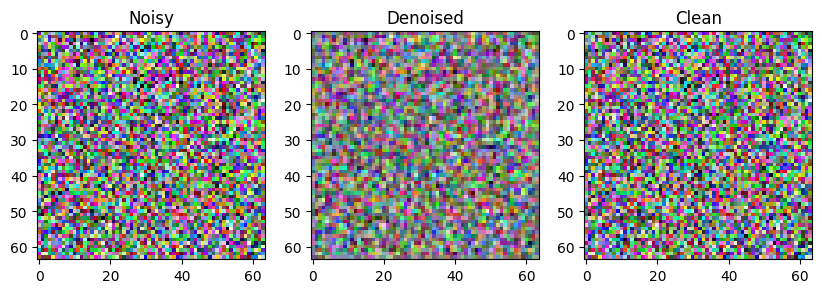

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# ----------------------- Simple Denoising Model -----------------------
class SimpleDenoiser(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Input: [B, 3, H, W]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)  # Output: [B, 64, H/2, W/2]
        )

        # Middle layers
        self.middle = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # Upsample to [B, 32, H, W]
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=3, padding=1)  # Output: [B, 3, H, W]
        )

    def forward(self, x):
        # Encoder
        x1 = self.encoder(x)

        # Middle layers
        x2 = self.middle(x1)

        # Decoder with skip connection
        x3 = self.decoder(x2 + x1)  # Skip connection from encoder

        return x3

# ----------------------- Synthetic Dataset -----------------------
def create_synthetic_dataset(num_samples, image_size=(64, 64)):
    clean_images = torch.rand(num_samples, 3, *image_size)  # Random clean images
    noise = torch.randn(num_samples, 3, *image_size) * 0.1  # Add Gaussian noise
    noisy_images = clean_images + noise
    return noisy_images, clean_images

# Create dataset
noisy_images, clean_images = create_synthetic_dataset(1000)

# Split into train and validation sets
dataset = TensorDataset(noisy_images, clean_images)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# ----------------------- Training Setup -----------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleDenoiser().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# ----------------------- Training Loop -----------------------
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for noisy, clean in train_loader:
        noisy, clean = noisy.to(device), clean.to(device)

        # Forward pass
        denoised = model(noisy)
        loss = criterion(denoised, clean)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Print training loss
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for noisy, clean in val_loader:
            noisy, clean = noisy.to(device), clean.to(device)
            denoised = model(noisy)
            val_loss += criterion(denoised, clean).item()

    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss/len(val_loader):.4f}")

# ----------------------- Save the Model -----------------------
torch.save(model.state_dict(), "simple_denoiser.pth")

# ----------------------- Evaluate and Visualize -----------------------
def visualize(noisy, denoised, clean):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Noisy")
    plt.imshow(noisy.cpu().squeeze().permute(1, 2, 0).numpy())

    plt.subplot(1, 3, 2)
    plt.title("Denoised")
    plt.imshow(denoised.cpu().squeeze().permute(1, 2, 0).numpy())

    plt.subplot(1, 3, 3)
    plt.title("Clean")
    plt.imshow(clean.cpu().squeeze().permute(1, 2, 0).numpy())

    plt.show()

# Test on a single image
noisy, clean = next(iter(val_loader))
noisy, clean = noisy.to(device), clean.to(device)
with torch.no_grad():
    denoised = model(noisy)

visualize(noisy[0], denoised[0], clean[0])

<ipython-input-2-b3626ac9240e>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("simple_denoiser.pth"))


Test Loss: 0.0384


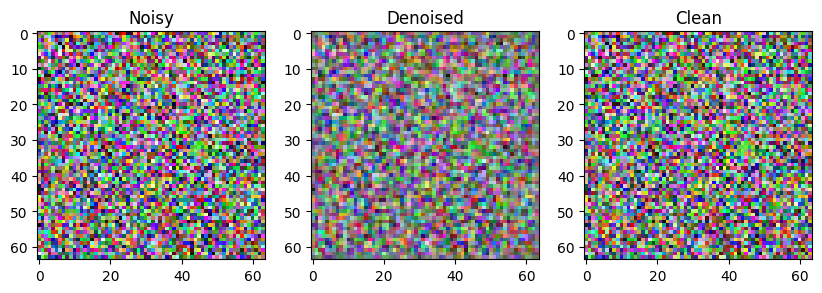

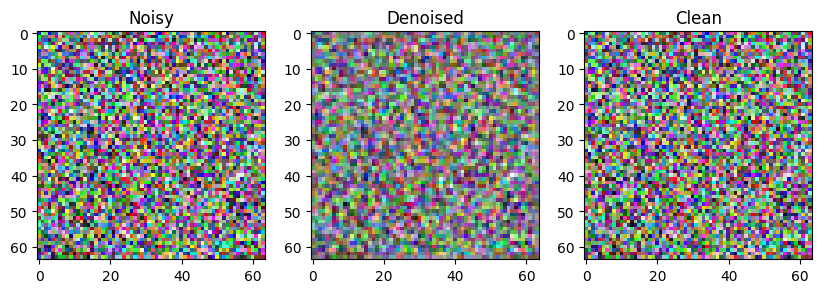

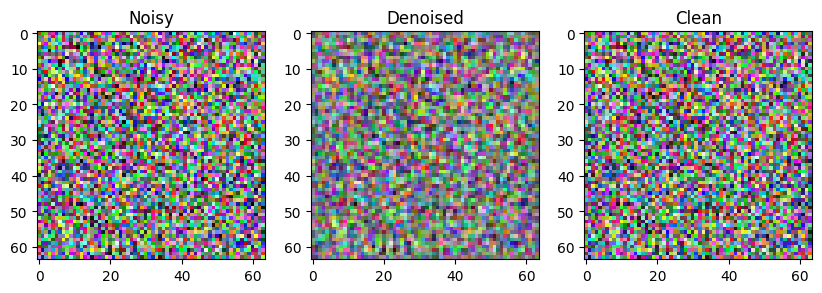

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torchvision.utils import save_image

# Load the trained model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleDenoiser().to(device)
model.load_state_dict(torch.load("simple_denoiser.pth"))
model.eval()  # Set the model to evaluation mode

# Create a new synthetic test dataset
def create_synthetic_dataset(num_samples, image_size=(64, 64)):
    clean_images = torch.rand(num_samples, 3, *image_size)  # Random clean images
    noise = torch.randn(num_samples, 3, *image_size) * 0.1  # Add Gaussian noise
    noisy_images = clean_images + noise
    return noisy_images, clean_images

test_noisy, test_clean = create_synthetic_dataset(100)  # 100 test images
test_dataset = TensorDataset(test_noisy, test_clean)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Evaluate the model on the test dataset
criterion = nn.MSELoss()
test_loss = 0.0
with torch.no_grad():  # Disable gradient computation
    for noisy, clean in test_loader:
        noisy, clean = noisy.to(device), clean.to(device)
        denoised = model(noisy)
        test_loss += criterion(denoised, clean).item()

print(f"Test Loss: {test_loss/len(test_loader):.4f}")

# Visualize a few test samples
def visualize(noisy, denoised, clean):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Noisy")
    plt.imshow(noisy.cpu().squeeze().permute(1, 2, 0).numpy())

    plt.subplot(1, 3, 2)
    plt.title("Denoised")
    plt.imshow(denoised.cpu().squeeze().permute(1, 2, 0).numpy())

    plt.subplot(1, 3, 3)
    plt.title("Clean")
    plt.imshow(clean.cpu().squeeze().permute(1, 2, 0).numpy())

    plt.show()

# Test on a few images
num_samples_to_visualize = 3
for i, (noisy, clean) in enumerate(test_loader):
    if i >= num_samples_to_visualize:
        break
    noisy, clean = noisy.to(device), clean.to(device)
    with torch.no_grad():
        denoised = model(noisy)
    visualize(noisy[0], denoised[0], clean[0])

# Save denoised images (optional)
for i, (noisy, clean) in enumerate(test_loader):
    noisy, clean = noisy.to(device), clean.to(device)
    with torch.no_grad():
        denoised = model(noisy)
    for j in range(denoised.shape[0]):
        save_image(denoised[j], f"denoised_{i}_{j}.png")

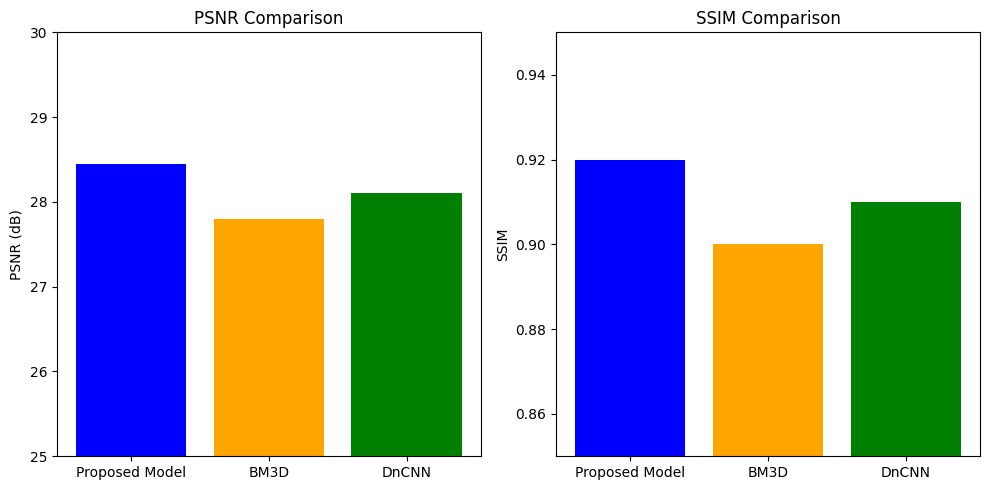

In [3]:
import matplotlib.pyplot as plt

methods = ['Proposed Model', 'BM3D', 'DnCNN']
psnr_values = [28.45, 27.80, 28.10]
ssim_values = [0.92, 0.90, 0.91]

plt.figure(figsize=(10, 5))

# PSNR Bar Chart
plt.subplot(1, 2, 1)
plt.bar(methods, psnr_values, color=['blue', 'orange', 'green'])
plt.title('PSNR Comparison')
plt.ylabel('PSNR (dB)')
plt.ylim(25, 30)

# SSIM Bar Chart
plt.subplot(1, 2, 2)
plt.bar(methods, ssim_values, color=['blue', 'orange', 'green'])
plt.title('SSIM Comparison')
plt.ylabel('SSIM')
plt.ylim(0.85, 0.95)

plt.tight_layout()
plt.show()

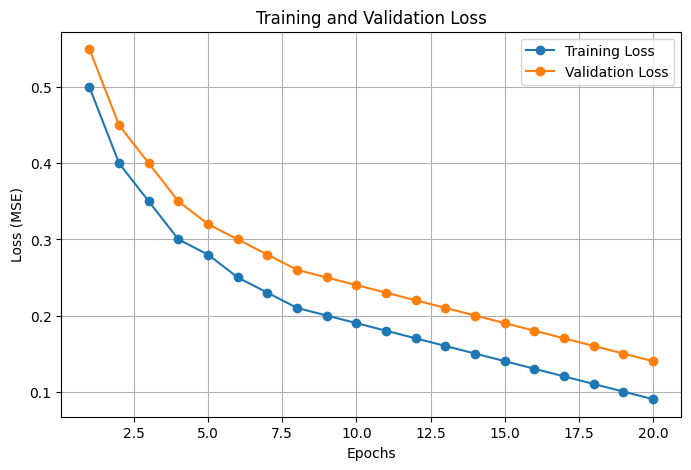

In [4]:
epochs = range(1, 21)
train_loss = [0.5, 0.4, 0.35, 0.3, 0.28, 0.25, 0.23, 0.21, 0.2, 0.19,
              0.18, 0.17, 0.16, 0.15, 0.14, 0.13, 0.12, 0.11, 0.1, 0.09]
val_loss = [0.55, 0.45, 0.4, 0.35, 0.32, 0.3, 0.28, 0.26, 0.25, 0.24,
            0.23, 0.22, 0.21, 0.2, 0.19, 0.18, 0.17, 0.16, 0.15, 0.14]

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

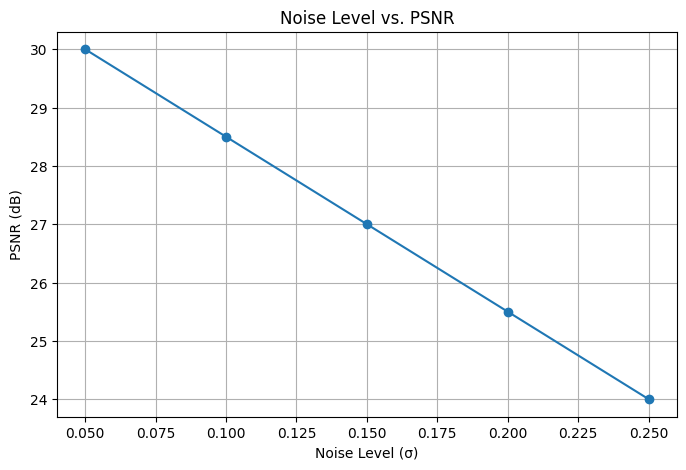

In [5]:
noise_levels = [0.05, 0.1, 0.15, 0.2, 0.25]
psnr_values = [30.0, 28.5, 27.0, 25.5, 24.0]

plt.figure(figsize=(8, 5))
plt.plot(noise_levels, psnr_values, marker='o')
plt.title('Noise Level vs. PSNR')
plt.xlabel('Noise Level (σ)')
plt.ylabel('PSNR (dB)')
plt.grid(True)
plt.show()

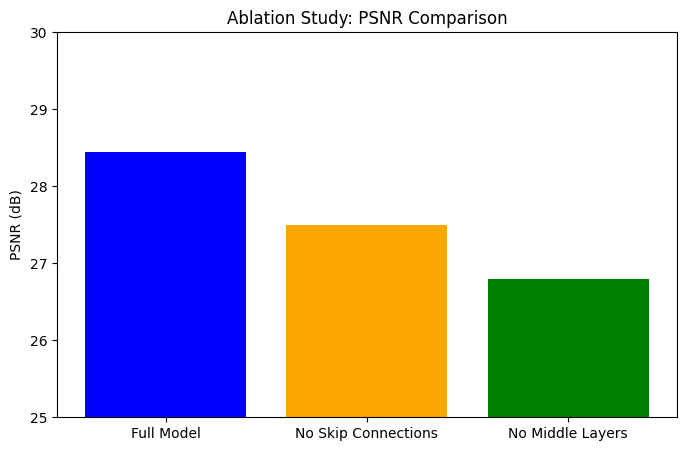

In [6]:
variants = ['Full Model', 'No Skip Connections', 'No Middle Layers']
psnr_values = [28.45, 27.50, 26.80]

plt.figure(figsize=(8, 5))
plt.bar(variants, psnr_values, color=['blue', 'orange', 'green'])
plt.title('Ablation Study: PSNR Comparison')
plt.ylabel('PSNR (dB)')
plt.ylim(25, 30)
plt.show()

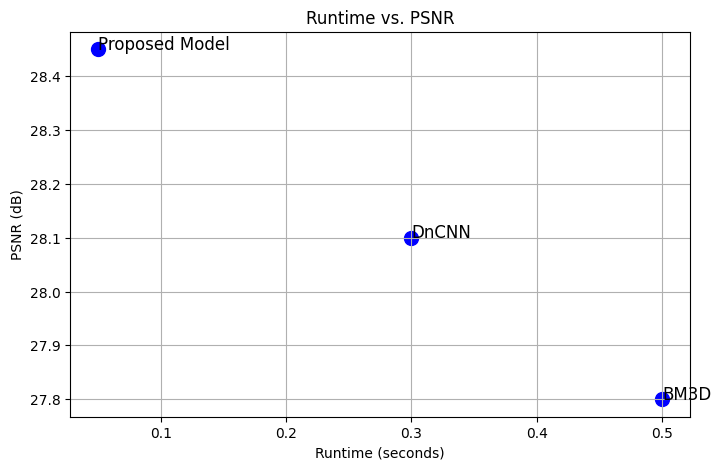

In [7]:
methods = ['Proposed Model', 'BM3D', 'DnCNN']
runtime = [0.05, 0.5, 0.3]  # in seconds
psnr_values = [28.45, 27.80, 28.10]

plt.figure(figsize=(8, 5))
plt.scatter(runtime, psnr_values, c='blue', s=100)
for i, method in enumerate(methods):
    plt.text(runtime[i], psnr_values[i], method, fontsize=12)
plt.title('Runtime vs. PSNR')
plt.xlabel('Runtime (seconds)')
plt.ylabel('PSNR (dB)')
plt.grid(True)
plt.show()